# Double Resolution of Provided Grid



In [66]:
# conda env - xgcm

# resample grid

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe


# load in chassignet & xu 2017 - a 1/12th degree resolution dataset
grid = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/regional.mom6.nc")

# v2 - southern boundary at 5 North - this looks like the winner
latMinInd = 860
latMaxInd = 2550
lonMinInd = 0
lonMaxInd = 1550

# subselect
subgrid = grid.isel(nyp=slice(latMinInd, latMaxInd+1), nxp=slice(lonMinInd,lonMaxInd+1), ny=slice(latMinInd, latMaxInd), nx=slice(lonMinInd,lonMaxInd))
subgrid

np.count_nonzero(np.isnan(subgrid.x.values))

0

In [67]:

# trying air temp example - http://xarray.pydata.org/en/stable/user-guide/interpolation.html#example
#new_lon = np.linspace(ds.lon[0], ds.lon[-1], ds.dims["lon"] * 4)
subgrid_interp = subgrid.interp(nxp=np.linspace(subgrid.nxp[0], subgrid.nxp[-1], subgrid.dims['nxp']*2), 
                                nyp=np.linspace(subgrid.nyp[0], subgrid.nyp[-1], subgrid.dims['nyp']*2),
                                nx=np.linspace(subgrid.nx[0], subgrid.nx[-1], subgrid.dims['nx']*2), 
                                ny=np.linspace(subgrid.ny[0], subgrid.ny[-1], subgrid.dims['ny']*2))
subgrid_interp

<xarray.Dataset>
Dimensions:   (nx: 3100, nxp: 3102, ny: 3380, nyp: 3382)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x         (nyp, nxp) float64 -98.04 -98.02 -98.0 ... -37.19 -37.17 -37.15
    y         (nyp, nxp) float64 5.233 5.233 5.233 5.233 ... 58.18 58.18 58.18
    angle_dx  (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 ... 6.95 6.96 6.948 6.936
    dx        (nyp, nx) float64 4.435e+03 4.435e+03 ... 2.471e+03 2.472e+03
    dy        (ny, nxp) float64 4.434e+03 4.434e+03 ... 2.32e+03 2.32e+03
    area      (ny, nx) float64 1.966e+07 1.966e+07 ... 5.733e+06 5.734e+06
    tile      |S255 ...
    nxp       (nxp) float64 0.0 0.4998 0.9997 ... 1.549e+03 1.55e+03 1.55e+03
    nyp       (nyp) float64 0.0 0.4999 0.9997 ... 1.689e+03 1.69e+03 1.69e+03
    nx        (nx) float64 0.0 0.4998 0.9997 ... 1.548e+03 1.549e+03 1.549e+03
    ny        (ny) float64 0.0 0.4999 0.9997 ... 1.688e+03 1.689e+03 1.689e+03
Attributes:
    history:  grid_hycom2mom6

In [68]:
# double check there are no introduced NaNs
np.count_nonzero(np.isnan(subgrid_interp.x.values))

0

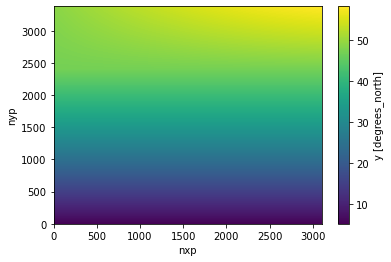

In [70]:
subgrid_interp.y.plot()

In [ ]:
subgrid_interp.to_netcdf("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/nwa25_interped.nc")

# Interpolate Bathymetry

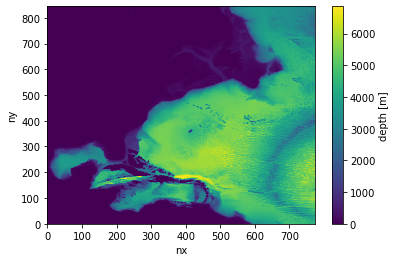

In [138]:
topo = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/depth_ATLb0.08_09m11_mom6.nc")
subtopo = topo.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))
subtopo.depth.plot()

In [144]:
subtopo_interp = subtopo.interp(nx=np.linspace(subtopo.nx[0], subtopo.nx[-1], subtopo.dims['nx']*2), 
                                ny=np.linspace(subtopo.ny[0], subtopo.ny[-1], subtopo.dims['ny']*2))

subtopo_interp

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690)
Dimensions without coordinates: nx, ny
Data variables:
    depth    (ny, nx) float64 0.0 0.0 0.0 0.0 ... 2.923e+03 2.914e+03 2.904e+03
    wet      (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    nx       (nx) float64 0.0 0.4997 0.9994 1.499 ... 772.5 773.0 773.5 774.0
    ny       (ny) float64 0.0 0.4997 0.9994 1.499 ... 842.5 843.0 843.5 844.0
Attributes:
    comment:  depth_GLBb0.08_09m11 subregioned to ATLb0.08 via isuba_topog | ...
    history:  topo_2mom6

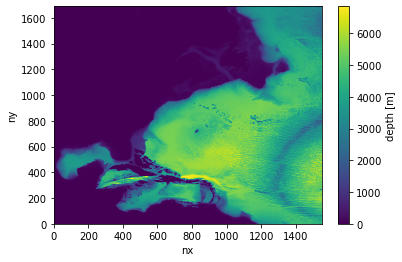

In [145]:
subtopo_interp.depth.plot()

In [146]:
np.count_nonzero(np.isnan(subtopo_interp.depth.values))

0

Text(0.5, 1.0, 'NWA25')

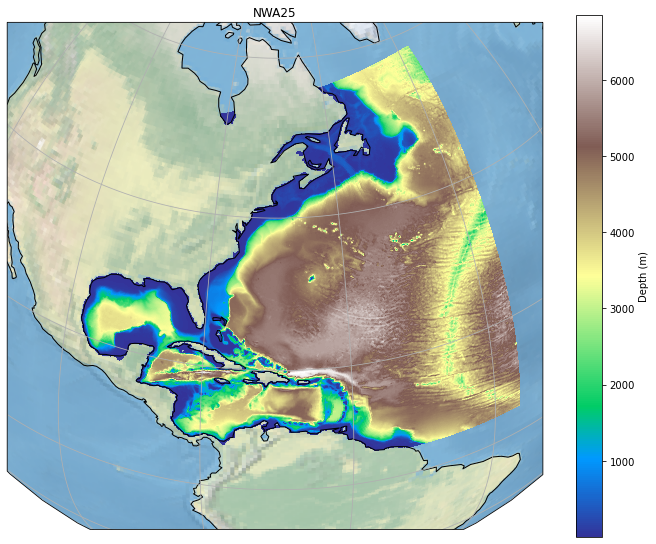

In [148]:
sg = subgrid_interp.coarsen(nxp=2, nyp=2,boundary="trim").mean()

#subtopo_interp.depth.values = subtopo_interp.depth.where(subtopo_interp['depth'].values > 0.01,np.nan)
import cartopy.crs as crs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
#subtopo.depth.values = subtopo.depth.where(subtopo.depth!=0)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.NearsidePerspective(central_latitude=45, central_longitude=290))
ax.set_extent([-110, -30, -10,60], crs=crs.PlateCarree())
im = ax.pcolormesh(sg.x.values, sg.y.values, subtopo_interp.depth.where(subtopo_interp['depth'].values > 0.01,np.nan), transform=crs.PlateCarree(), cmap='terrain')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.stock_img()
ax.coastlines()
ax.gridlines()
plt.title("NWA25")

In [75]:
subtopo_interp.to_netcdf("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/nwa25_topo.nc")

# Interpolate Land Masks

In [113]:
land = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/land_mask.nc")


In [79]:
land

<xarray.Dataset>
Dimensions:  (nx: 1678, ny: 1844)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  $Name:  $
    history:       make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_...

In [80]:
subland = land.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))

In [81]:
subland_interp = subland.interp(nx=np.linspace(land.nx[0], subland.nx[-1], subland.dims['nx']*2), 
                                ny=np.linspace(land.ny[0], subland.ny[-1], subland.dims['ny']*2))

In [82]:
subland_interp

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    nx       (nx) float64 0.0 0.4997 0.9994 1.499 ... 772.5 773.0 773.5 774.0
    ny       (ny) float64 0.0 0.4997 0.9994 1.499 ... 842.5 843.0 843.5 844.0
Attributes:
    grid_version:  0.2
    code_version:  $Name:  $
    history:       make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_...

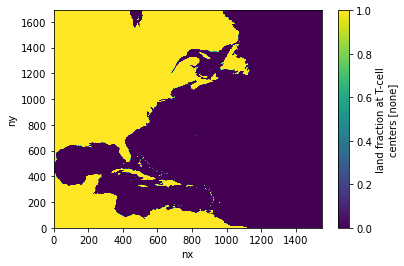

In [83]:
subland_interp.mask.plot()

# Mask out Hudson Bay

In [110]:
hudson = subland_interp
for y in range(1500,len(hudson.ny)):
    for x in range(400,600):
        if y > 1500 and x < 600:
            hudson.mask[y,x] = 1.

In [111]:
hudson

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    nx       (nx) float64 0.0 0.4997 0.9994 1.499 ... 772.5 773.0 773.5 774.0
    ny       (ny) float64 0.0 0.4997 0.9994 1.499 ... 842.5 843.0 843.5 844.0
Attributes:
    grid_version:  0.2
    code_version:  $Name:  $
    history:       make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_...

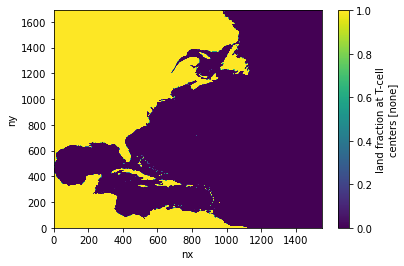

In [112]:
hudson.mask.plot()

In [117]:
subland_interp = hudson
subland_interp.to_netcdf("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/nwa25_land_mask.nc")

# Interpolate Ocean Mask & Cover Hudson Bay

In [114]:

ocean = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/ocean_mask.nc")
ocean

<xarray.Dataset>
Dimensions:  (nx: 1678, ny: 1844)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  $Name:  $
    history:       make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_...

In [121]:
subocean = ocean.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))

subocean_interp = subocean.interp(nx=np.linspace(land.nx[0], subocean.nx[-1], subocean.dims['nx']*2), 
                                ny=np.linspace(land.ny[0], subocean.ny[-1], subocean.dims['ny']*2))

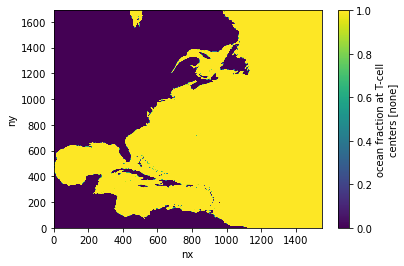

In [122]:
subocean_interp.mask.plot()

In [123]:
hudson = subocean_interp
for y in range(1500,len(hudson.ny)):
    for x in range(400,600):
        if y > 1500 and x < 600:
            hudson.mask[y,x] = 0.

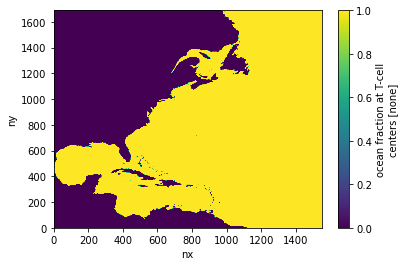

In [124]:
hudson.mask.plot()

In [125]:
subocean_interp = hudson
subocean_interp.to_netcdf("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/nwa25_ocean_mask.nc")